In [1]:
# Install Ultralytics
!pip install ultralytics --quiet

# Import modules
from ultralytics import YOLO
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyti

In [2]:
# Upload your custom trained license plate detector (e.g., best.pt)
print("Upload your license plate detection model (.pt):")
from google.colab import files
uploaded_model = files.upload()

# Get uploaded filename
plate_model_path = next(iter(uploaded_model))

# Load the license plate model
from ultralytics import YOLO
plate_model = YOLO(plate_model_path)

# Load the vehicle model (pretrained on COCO)
vehicle_model = YOLO('yolov8n.pt')


Upload your license plate detection model (.pt):


Saving best.pt to best.pt


In [3]:
import cv2
from PIL import Image

In [12]:
# Upload an image
print("Upload a sample vehicle image:")
uploaded = files.upload()
image_path = next(iter(uploaded))

# Open and convert to RGB
image = Image.open(image_path).convert('RGB')
image_np = np.array(image)

# Step 1: Convert RGB to HSV
hsv = cv2.cvtColor(image_np, cv2.COLOR_RGB2HSV)

# Step 2: Convert to Grayscale
gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)

# Step 3: Normalize grayscale image with Min-Max scaling (0–1)
gray_norm = (gray - gray.min()) / (gray.max() - gray.min())

# Step 4: Convert normalized grayscale back to 3 channels
gray_norm_3ch = np.stack([gray_norm]*3, axis=-1)

# Convert back to uint8 and scale to 0–255 for YOLO input
processed_image = (gray_norm_3ch * 255).astype(np.uint8)

# Optional: show result
# plt.imshow(processed_image)
# plt.axis('off')
# plt.title("Preprocessed Image")
# plt.show()


Upload a sample vehicle image:


Saving green_number_plate.jpeg to green_number_plate.jpeg



image 1/1 /content/green_number_plate.jpeg: 640x480 1 car, 216.5ms
Speed: 4.8ms preprocess, 216.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

✅ Detected 1 vehicle(s).


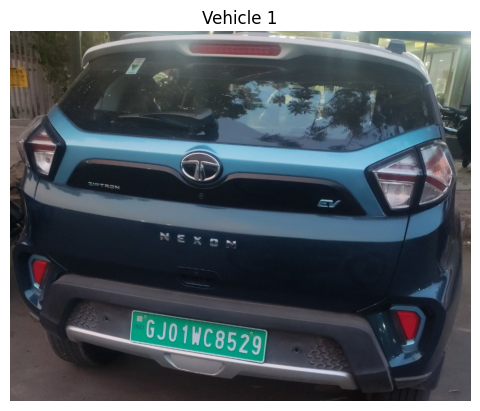

In [13]:
# Vehicle detection
vehicle_results = vehicle_model(image_path)[0]
vehicle_classes = [2, 3, 5, 7]  # COCO vehicle classes
vehicle_bboxes = [box for box in vehicle_results.boxes if int(box.cls) in vehicle_classes]

print(f"\n✅ Detected {len(vehicle_bboxes)} vehicle(s).")

# Crop and show each vehicle
cropped_vehicles = []

for i, box in enumerate(vehicle_bboxes):
    x1, y1, x2, y2 = map(int, box.xyxy[0])
    vehicle_crop = image.crop((x1, y1, x2, y2))
    cropped_vehicles.append((vehicle_crop, (x1, y1)))

    plt.imshow(vehicle_crop)
    plt.axis('off')
    plt.title(f"Vehicle {i+1}")
    plt.show()



0: 416x512 1 license-plate, 136.6ms
Speed: 3.5ms preprocess, 136.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 512)


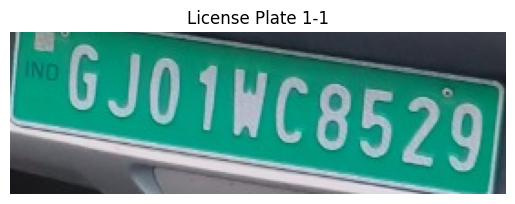

In [14]:
for i, (vehicle_crop, offset) in enumerate(cropped_vehicles):
    crop_np = np.array(vehicle_crop)
    plate_results = plate_model(crop_np)[0]

    if len(plate_results.boxes) == 0:
        print(f"❌ No license plate found in vehicle {i+1}.")
        continue

    for j, plate_box in enumerate(plate_results.boxes):
        px1, py1, px2, py2 = map(int, plate_box.xyxy[0])
        px1_global, py1_global = px1 + offset[0], py1 + offset[1]
        px2_global, py2_global = px2 + offset[0], py2 + offset[1]

        plate_crop = image.crop((px1_global, py1_global, px2_global, py2_global))

        plt.imshow(plate_crop)
        plt.axis('off')
        plt.title(f"License Plate {i+1}-{j+1}")
        plt.show()
